# 0.0. IMPORTS

In [138]:
import math
import pickle
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import xgboost as xgb


from scipy                 import stats
from boruta                import BorutaPy
from datetime              import datetime, timedelta
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [112]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range( 1, kfold+1 )):
        if verbose:
            print( '\nKfold Number: {}'.format( k ))
        
        # start and end date for validation
        validation_start_date = x_training['date'].max() - timedelta( days= k*6*7 )
        validation_end_date = x_training['date'].max() - timedelta( days= (k-1)*6*7 )

        # filtering dataset 
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training dataset
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']


        # validation dataset
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining)


        # prediction 
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( 'Linear Regression', np.expm1(yvalidation), np.expm1(yhat) )

        # store performance of each Kfold iteration
        mae_list.append( m_result['MAE'] ) 
        mape_list.append( m_result['MAPE'] ) 
        rmse_list.append( m_result['RSME'] ) 

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype( str ) + ' +/- ' + np.round(np.std(mae_list), 2).astype( str ),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype( str ) + ' +/- ' + np.round(np.std(mape_list), 2).astype( str ),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype( str ) + ' +/- ' + np.round(np.std(rmse_list), 2).astype( str )}, index=[0])

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
        
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RSME': rmse}, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize']= [16,8]
    plt.rcParams['font.size'] = 18
    
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    #pd.options.display.max.columns = None
    #pd.options.display.max.rows = None
    pd.set_option( 'display.expand_frame_repr', False)
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/store_sales_predict/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading data

In [4]:
df_sale_raw = pd.read_csv( 'base de dados/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'base de dados/store.csv', low_memory=False)

In [5]:
df_sale_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
553760,391,4,2014-02-20,5706,736,1,1,0,0


In [6]:
df_store_raw.sample()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1007,1008,a,c,30.0,9.0,2010.0,0,NaN,NaN,NaN


In [7]:
df_raw = pd.merge( df_sale_raw, df_store_raw, how='left', on='Store')
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
474097,1008,6,2014-05-03,5325,746,1,0,0,0,a,c,30.0,9.0,2010.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [8]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']


snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#rename 

df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [12]:
print( f'Number of Rows: {df1.shape[0]}')
print( f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [13]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [15]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
978926,742,1,2013-02-04,11473,1092,1,1,0,0,d,c,4380.0,NaN,NaN,0,NaN,NaN,NaN


In [16]:
# competition_distance 

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month    

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year  

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)
                         
# promo2_since_week  

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)

# promo2_since_year 

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)

#promo_interval

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )
 
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis= 1 )

In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes( include= [ 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude= [ 'int64', 'float64', 'datetime64[ns]'] )

In [21]:
cat_attributes.sample()

,state_holiday,store_type,assortment,promo_interval,month_map
673207,0,a,c,0,Nov


### 1.7.1. Numerical Attributes

In [22]:
# Central Tendency - mean, median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtois 

d1 = pd.DataFrame( num_attributes.apply( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [23]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/opt/anaconda3/envs/store_sales_predict/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


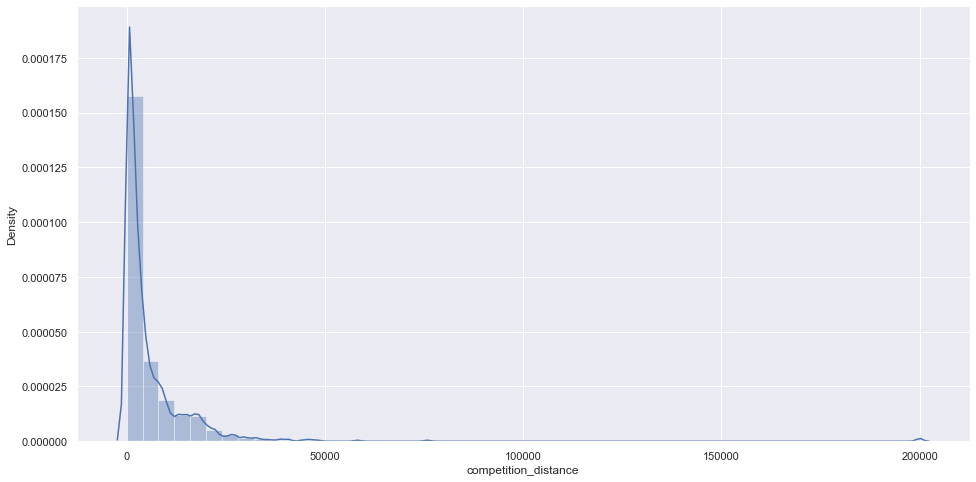

In [24]:
sns.distplot( df1['competition_distance'] );

### 1.7.2. Categorical Attributes

In [25]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

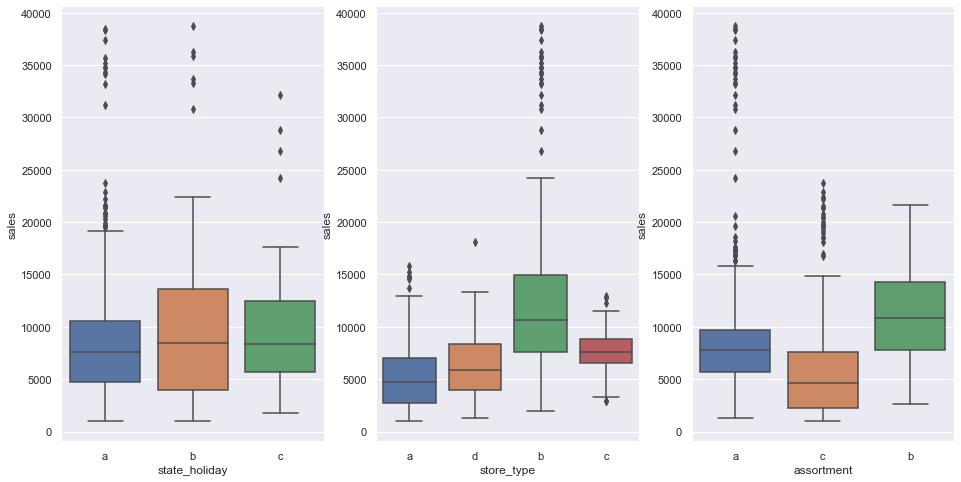

In [26]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

#plt.figure(figsize=(16, 8)) 

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday' ,y='sales' , data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type' ,y='sales' , data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment' ,y='sales' , data=aux1 )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [27]:
df2 = df1.copy()

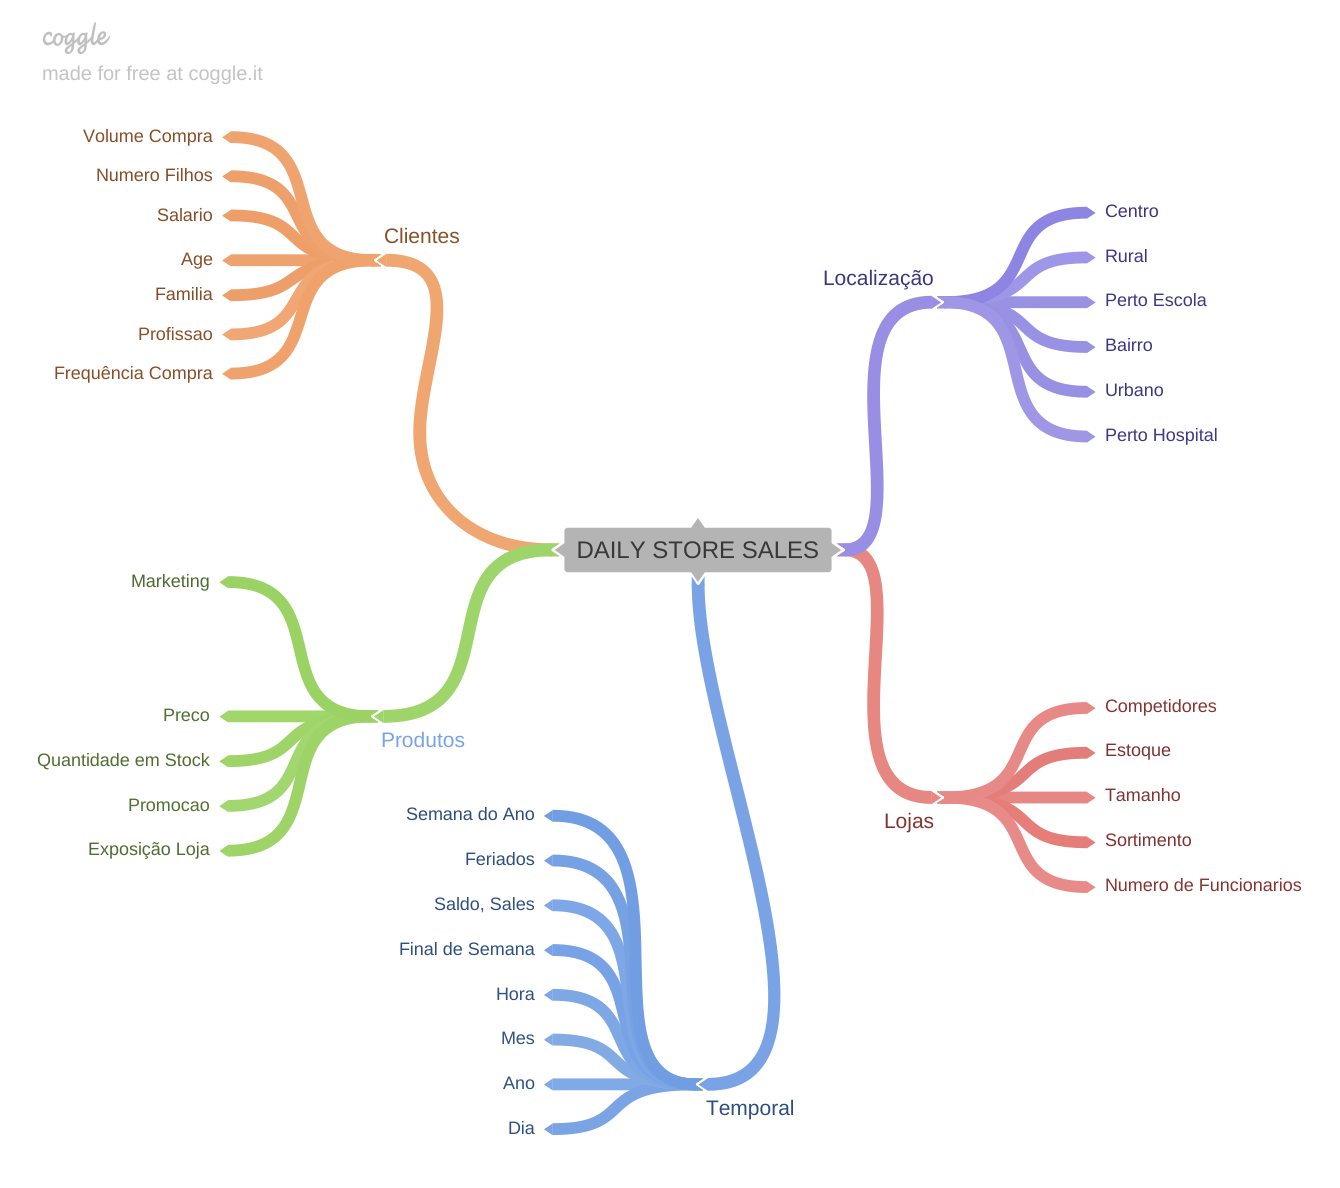

In [28]:
Image( 'images/MIndMapHypothesis.png')

## 2.1. Criacao de Hipótesis 

### 2.1.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais

**2.** Lojas com maior capacidade de estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais 

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.1.2 Hipóteses do produto

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas com maior exposicao do produtos deveriam vender mais

**3.** Lojas com produtos com menor preço deveriam vender mais

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoções deveriam vender mais

**7** Lojas com mais promoçoes consecultivas deveriam vender mais

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vnder mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender mais nos finais de semana

**6.** Lojas deveriam deveriam vender menos durante os feriados escolares

## 2.2 Lista de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoções deveriam vender mais

**6.** Lojas com mais promoçoes consecultivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vnder mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender mais nos finais de semana

**12.** Lojas deveriam deveriam vender menos durante os feriados escolares

## 2.3. Feature Engineering

In [29]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis= 1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply(lambda x: x.days).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

                                                                        
# assortment

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' ) 

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


<ipython-input-29-5d6149dfa277>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [30]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [31]:
df3 = df2.copy()

In [32]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1. Filtragem das Linhas

In [33]:
 df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

## 3.2. Seleção das Colunas

In [34]:
cols_drop = ['customers' , 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis= 1 )

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [36]:
df4 = df3.copy()

## 4.1. Análise Univariada 

### 4.1.1. Response Variable

/opt/anaconda3/envs/store_sales_predict/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


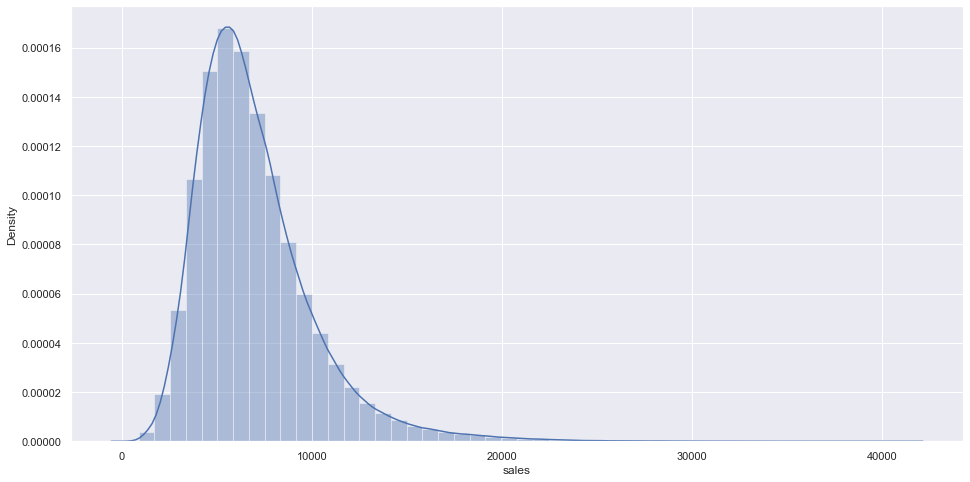

In [37]:
#f, ax = plt.subplots(figsize=(15, 7))
sns.distplot( df4['sales'] );

/opt/anaconda3/envs/store_sales_predict/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


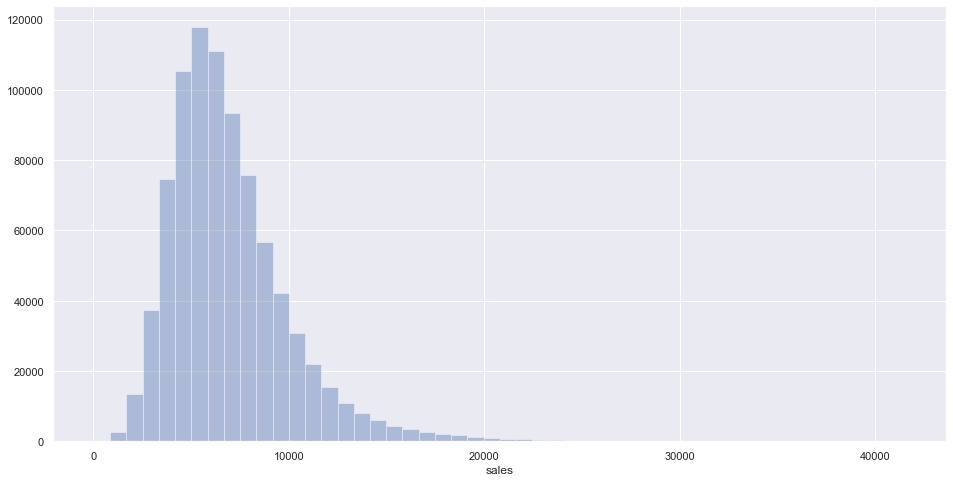

In [38]:
#f, ax = plt.subplots(figsize=(15, 7))
sns.distplot( df4['sales'], kde=False );

### 4.1.2 Numerical Variable

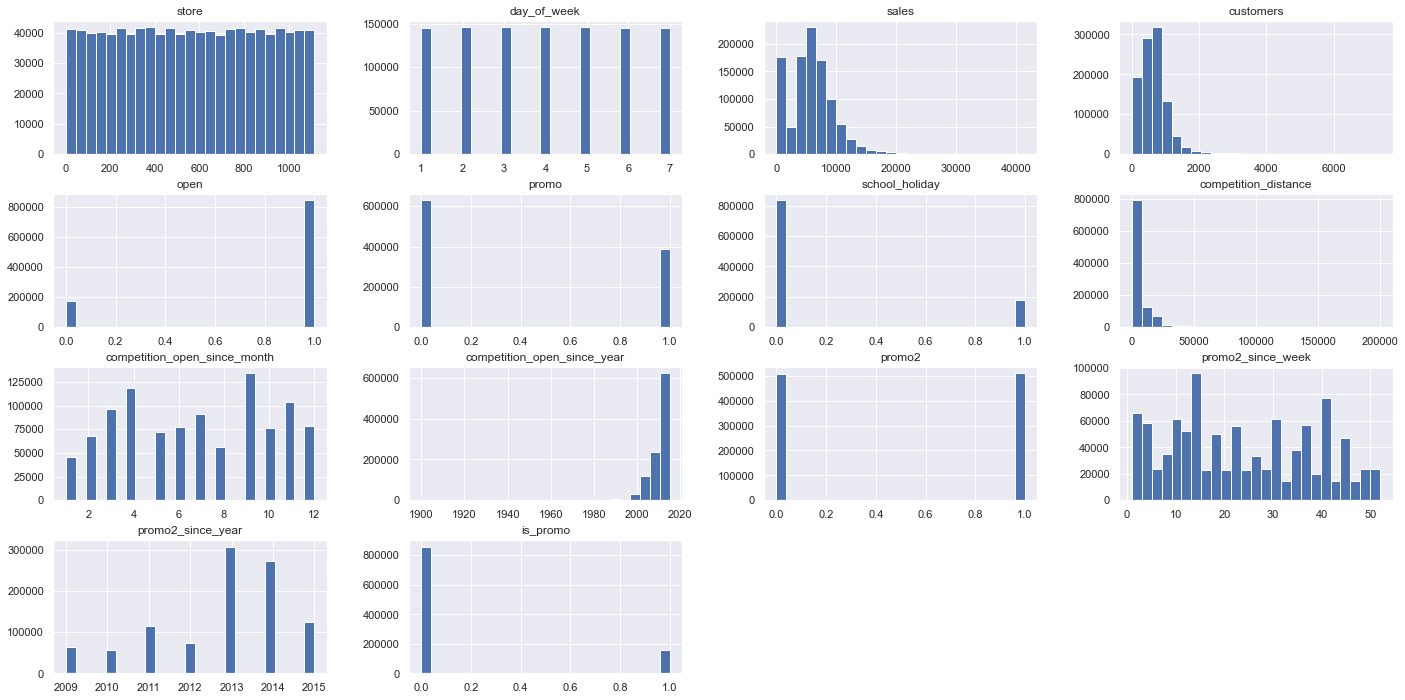

In [39]:
num_attributes.hist( bins=25, figsize=(24,12) );

### 4.1.3. Caregorical Variable

In [40]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [41]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/opt/anaconda3/envs/store_sales_predict/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/store_sales_predict/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/store_sales_predict/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an e

<AxesSubplot:xlabel='sales', ylabel='Density'>

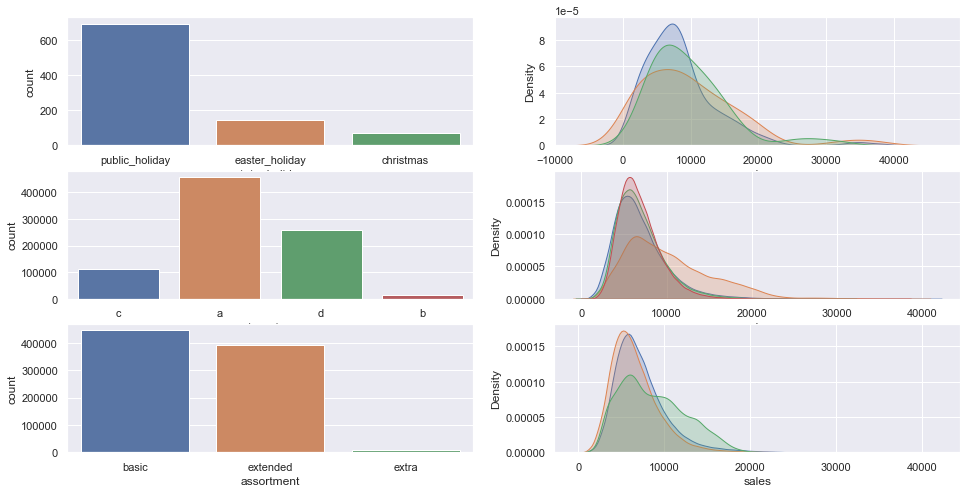

In [42]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day' ]
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='public_holiday', shade=True)

# store_type

plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment

plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2. Análise Bivariada 

### **H1.** Lojas com maior sortimento deveriam vender mais
**FALSA** Lojas com MAIOR SORTIMENTO vendem menos


<AxesSubplot:xlabel='year_week'>

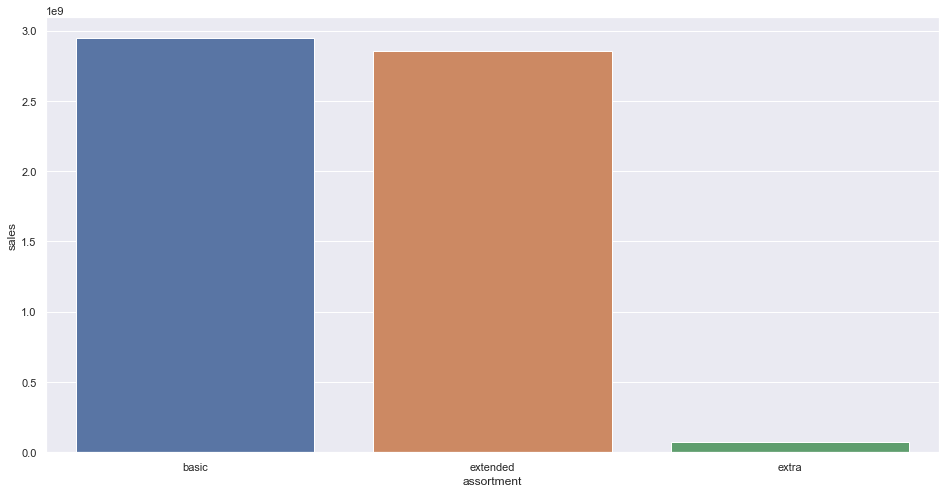

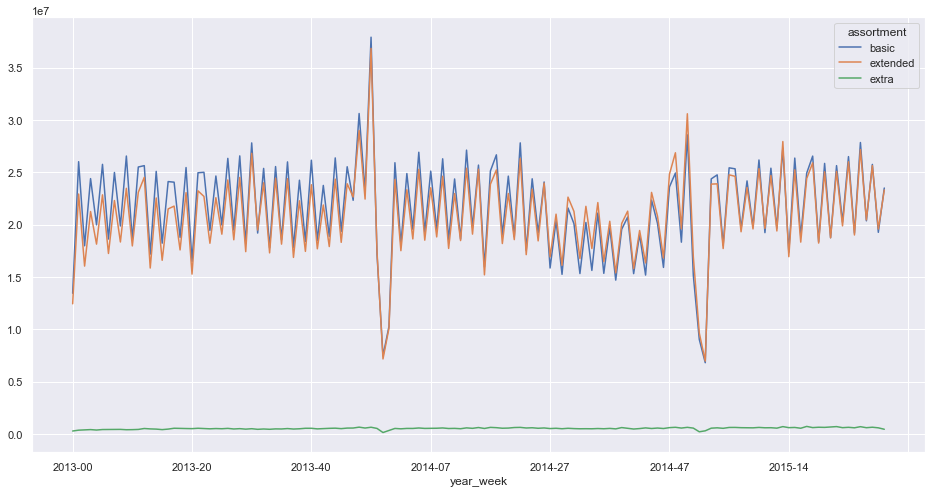

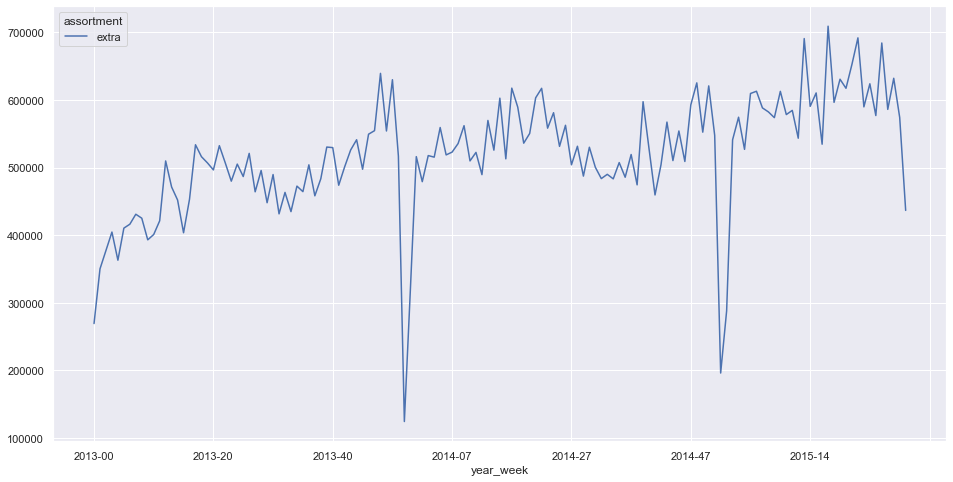

In [43]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()

#f, ax = plt.subplots(figsize=(15, 7))
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos
**FALSE** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS

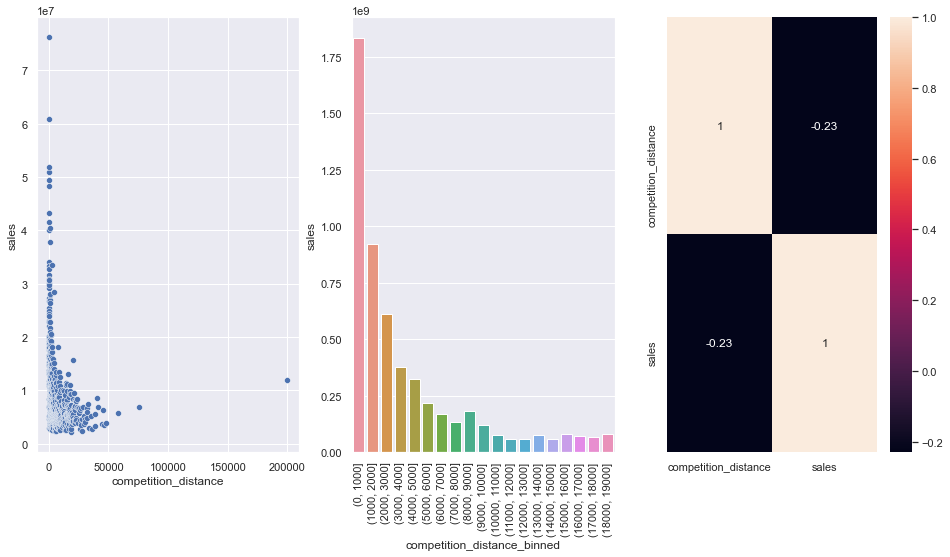

In [44]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

#plt.figure(figsize=(16, 8)) 

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );


plt.subplot( 1, 3, 2 )
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );


plt.subplot( 1, 3, 3 ), 
sns.heatmap( aux1.corr( method='pearson'), annot=True);

In [45]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
24,260.0,16536931,"(0, 1000]"
504,11640.0,4482889,"(11000, 12000]"
238,2920.0,5656109,"(2000, 3000]"
132,1470.0,4477750,"(1000, 2000]"


### **H3.** Lojas com competidores a mais tempo deveriam vender mais
**FALSE** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

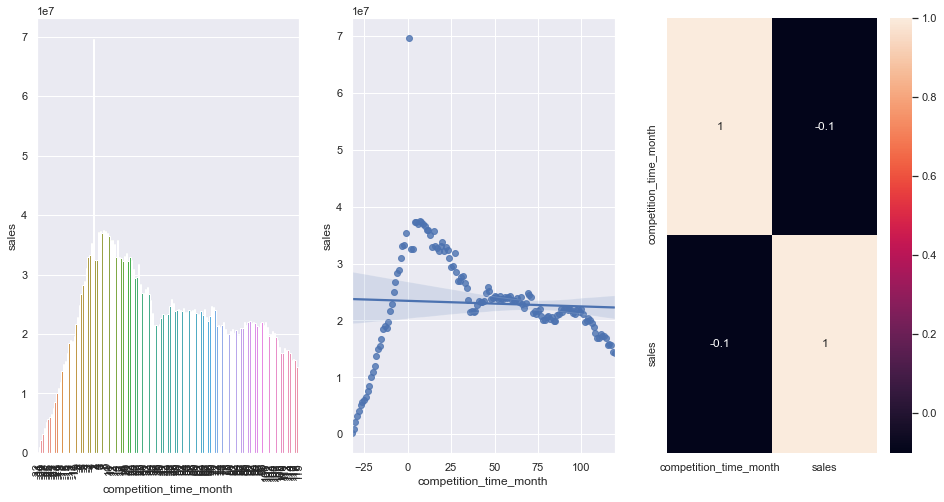

In [46]:
#plt.figure(figsize=(16, 8)) 

plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) &  (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson') ,annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSE** Lojas com promoçoes ativas por mais tempo vendem menos, depois de um certo período de promocao

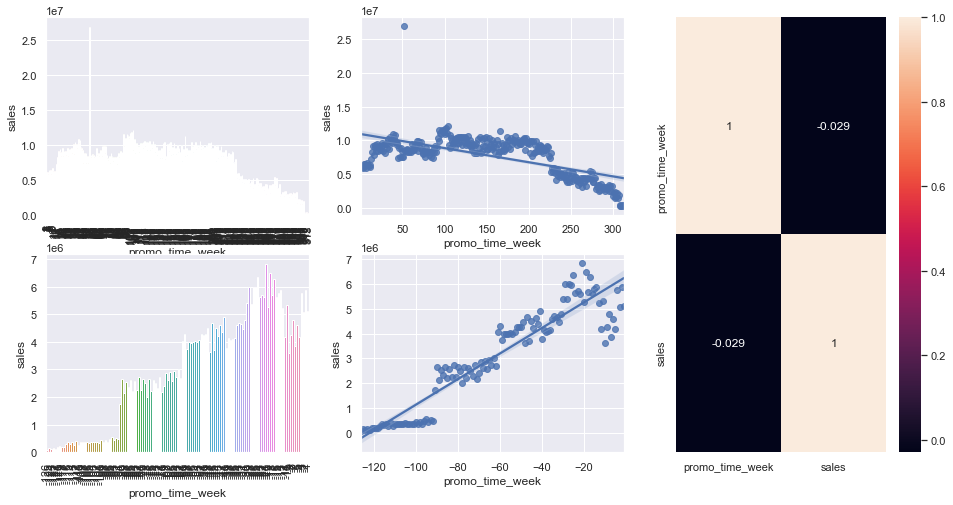

In [47]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

#plt.figure(figsize = (15,8))

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation = 90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2);

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation = 90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True);

### <s>**H5.** Lojas com mais dias de promoções deveriam vender mais</s>

### **H6.** Lojas com mais promoçoes consecultivas deveriam vender mais
**FALSA** Lojas com mais pormoçoes consecultivas vendem menos

In [48]:
df4[['promo', 'promo2','sales']].groupby( ['promo','promo2'] ).sum().sort_values('sales').reset_index()

,promo,promo2,sales
0,0,1,1289362241
1,1,1,1472275754
2,0,0,1482612096
3,1,0,1628930532


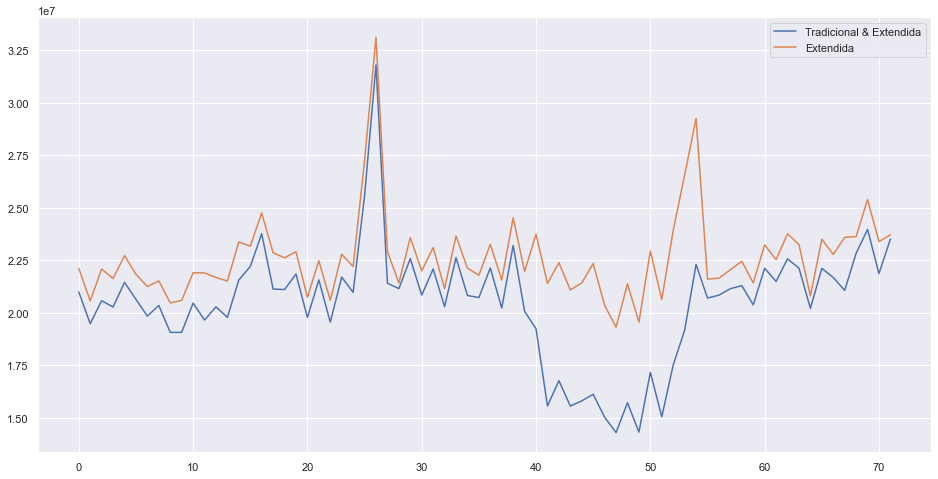

In [49]:
aux1 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax = ax )

ax.legend ( labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas abertas durante o feriado de natal vendem MENOS

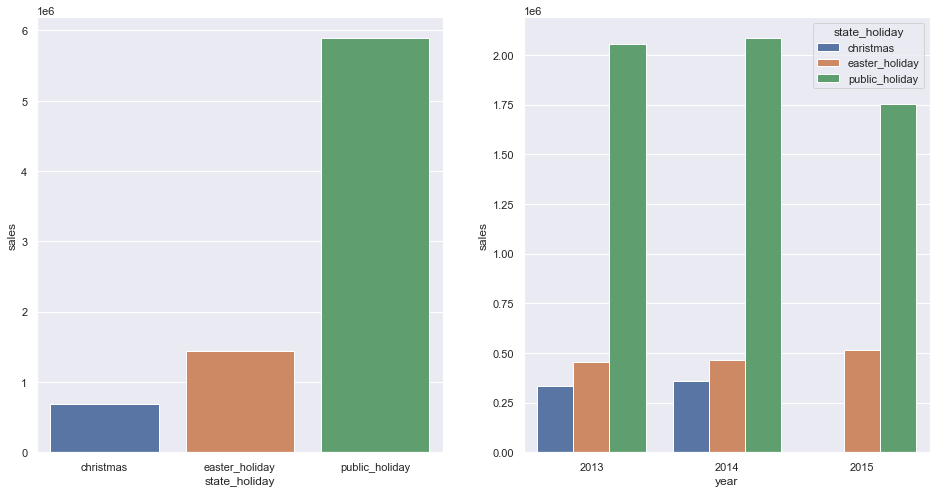

In [50]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot(x= 'state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem MENOS ao longo dos anos


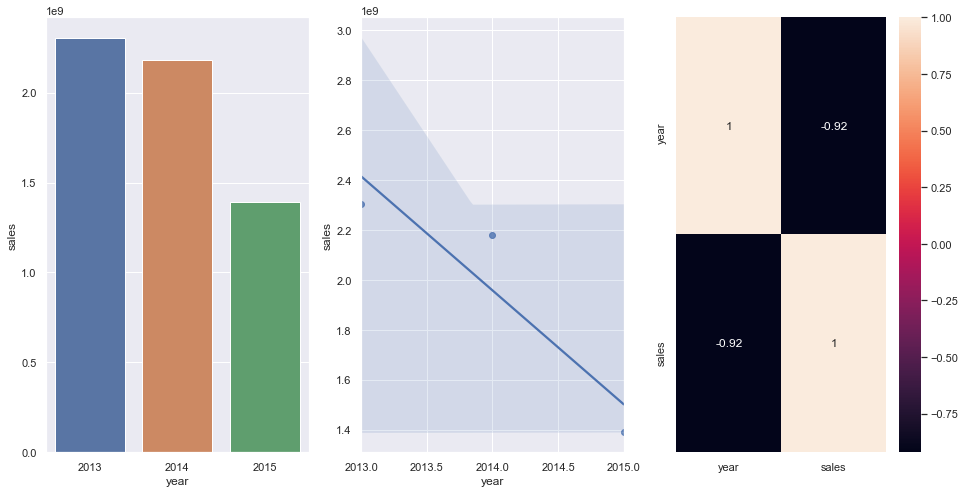

In [51]:
aux1 = df4[['year','sales']].groupby( 'year' ).sum().reset_index()

#plt.figure(figsize=(16, 8)) 

plt.subplot( 1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson') , annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem MENOS no segundo semestre do ano

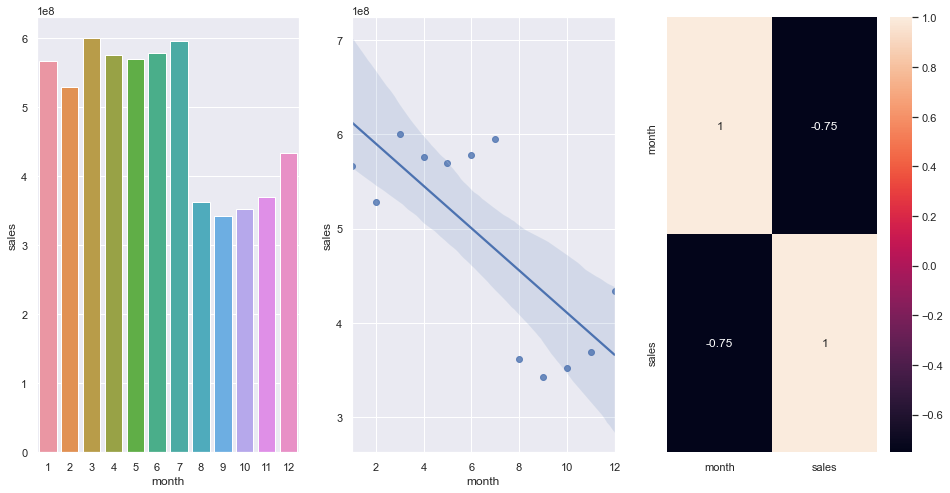

In [52]:
aux1 = df4[['month','sales']].groupby( 'month' ).sum().reset_index()

#plt.figure(figsize=(16, 8)) 

plt.subplot( 1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson') , annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mes

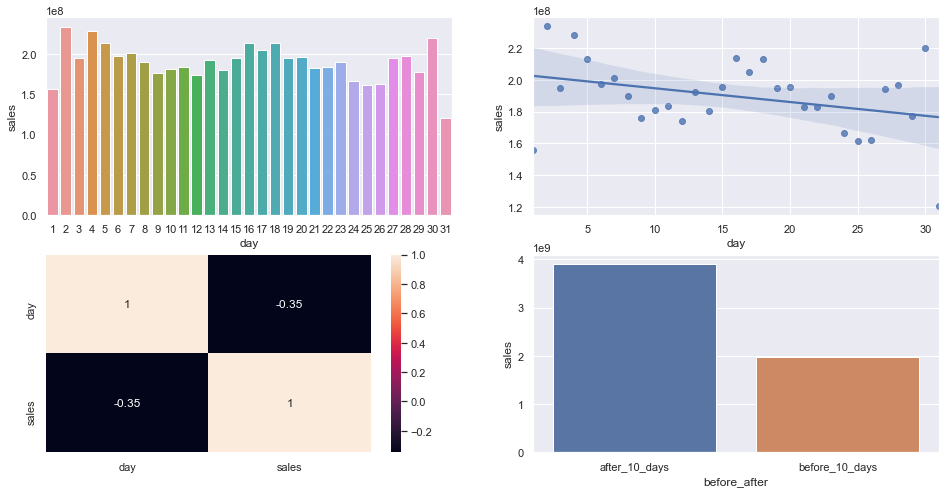

In [53]:
aux1 = df4[['day','sales']].groupby( 'day' ).sum().reset_index()

#plt.figure(figsize=(16, 8)) 

plt.subplot( 2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1);

plt.subplot( 2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1);

plt.subplot( 2, 2, 3)
sns.heatmap( aux1.corr( method='pearson') , annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender mais nos finais de semana
**FALSA** Lojas vendem MENOS nos finais de semana

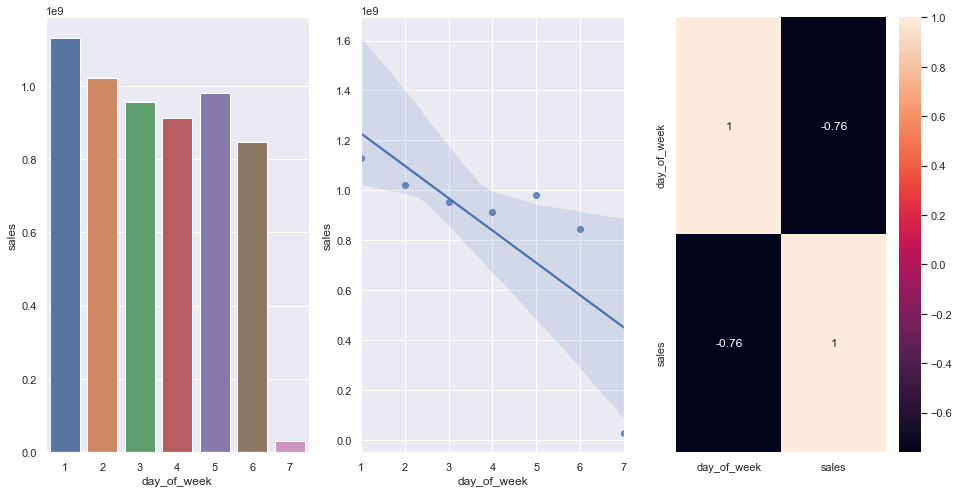

In [54]:
aux1 = df4[['day_of_week','sales']].groupby( 'day_of_week' ).sum().reset_index()

#plt.figure(figsize=(16, 8)) 

plt.subplot( 1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson') , annot=True);

### **H12.** Lojas deveriam deveriam vender menos durante os feriados escolares
**VERDEIRA** Lojas vendem MENOS durante os feriados escolares, exceto os meses de Julho e Agosto

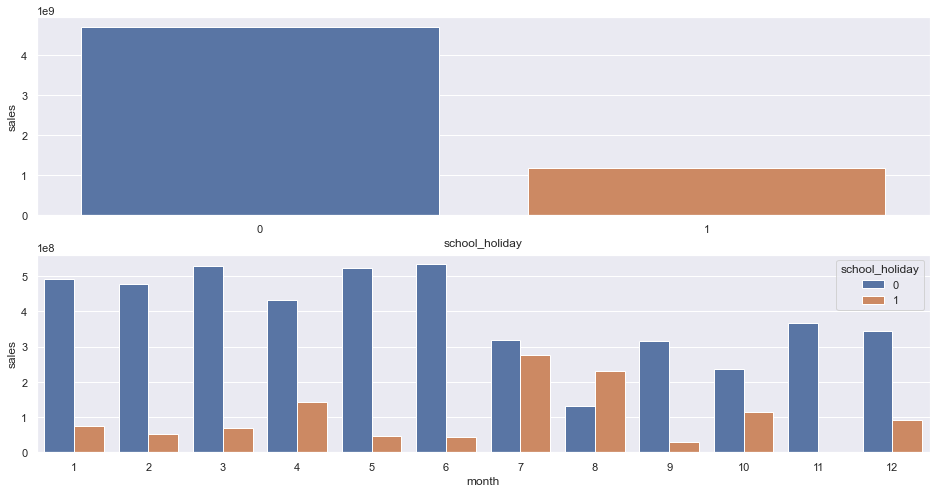

In [55]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday').sum().reset_index()

#plt.figure(figsize=(16,8))

plt.subplot( 2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot( 2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipóteses

In [56]:
from tabulate import tabulate

In [57]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'], 
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Baixa'], 
      ['H8', 'Falsa', 'Alta'], 
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Falsa', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
      ]
print( tabulate( tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Baixa
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Falsa        Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada 

### 4.3.1. Numerical Atributes

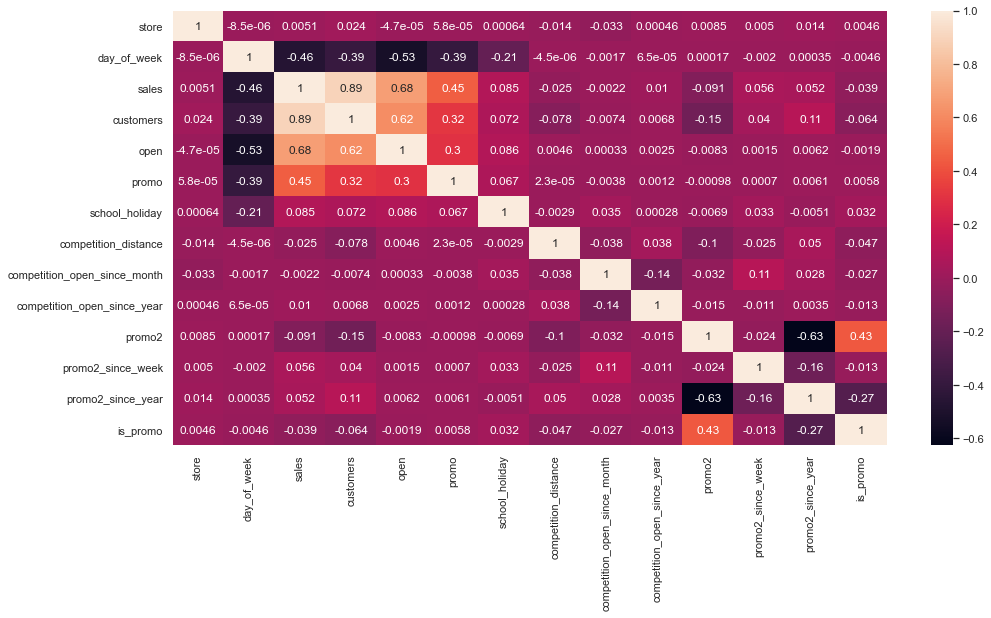

In [58]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True);

### 4.3.2. Categorical Atributes
Para analisar a correlaçao das variáveis categorica, o V de Cramer é o mais indicado

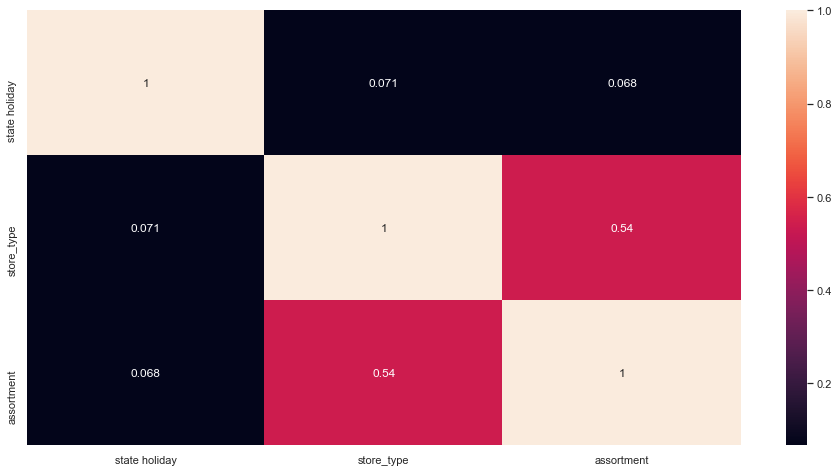

In [59]:
# Only Categorical data
a = df4.select_dtypes( include='object' )

# Calculate Cramer V
a1 = cramer_v ( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v ( a['state_holiday'], a['store_type'] )
a3 = cramer_v ( a['state_holiday'], a['assortment'] )

a4 = cramer_v ( a['store_type'], a['state_holiday'] )
a5 = cramer_v ( a['store_type'], a['store_type'] )
a6 = cramer_v ( a['store_type'], a['assortment'] )

a7 = cramer_v ( a['assortment'], a['state_holiday'] )
a8 = cramer_v ( a['assortment'], a['store_type'] )
a9 = cramer_v ( a['assortment'], a['assortment'] )

#Final Dataset
d = pd.DataFrame( {'state holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]            
              } )

d = d.set_index( d.columns )

sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - DATA PREPARATION

In [162]:
df5 = df4.copy()

## 5.1. Normalizacao
Nao iremos aplicar a normalizaçao porque nao há variávei com comportamento "normal"

## 5.2. Rescaling

In [163]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameters/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameters/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameters/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameters/year_scaler.pkl', 'wb') )

## 5.3. Transformacao

### 5.3.1. Encoding

In [161]:
#state_holiday - One Hot Encoding - representa um "estado"
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding - como nao sabemos se há uma ordem ordenamos aleatoriamente 
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameters/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encoding - Basic parece ser maior que Extra e menor que Extended
assortment_dic = {'basic': 1, 'extra': 2, 'extended':3}
df5['assortment'] = df5['assortment'].map( assortment_dic )

### 5.3.2. Response Variable Transformation

In [63]:
df5['sales'] = np.log1p( df5['sales'])

### 5.3.3. Nature Transformation
Transformacao realizadas em variáveis ciclicas - para diminuir a distancia

In [64]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x *( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x *( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x *( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x *( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x *( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x *( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x *( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x *( 2. * np.pi/52 ) ) )

In [65]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - FEATURE SELECTION

In [66]:
df6 = df5.copy()

## 6.1. Split DataFrame into traning and test dataset

In [67]:
cols_drop = [ 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]

df6 = df6.drop( cols_drop, axis=1 )

Como queremos a previsao de 6 semanas, conjunto de dados é um time series, o treino e teste será dividido em treino: até as 6 ultimas semanas e teste: 6 semanas finais

In [68]:
#verificando a data min e max

#df6[['store', 'date']].groupby( 'store' ).min().reset_index()
#df6[['store', 'date']].groupby( 'store' ).max().reset_index()

#pegando a data de inicio das ultimas 6 semanas 

df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=7*6 )

Timestamp('2015-06-19 00:00:00')

In [69]:
# Training Dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test Dataset

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format( X_train['date'].min() ) ) 
print('Training Max Date: {}'.format( X_train['date'].max() ) ) 

print('\nTest Min Date: {}'.format( X_test['date'].min() ) ) 
print('Test Max Date: {}'.format( X_test['date'].max() ) ) 

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selection


In [94]:
# Train and Test dataset for Boruta - o boruta exige que seja um vetor
X_train_n = X_train.drop( ['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf =  RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best Features from Boruta

In [95]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [96]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

## 6.3. Manual Feature Selection
Apos realizado o Boruta e comparado com a EDA, iremos criar as variáveis manualmente para nao ter que esperar sempre o tempo do Boruta - Comparado com a EDA iremos acrescentar, alem do Boruta, as features month_sin, week_of_year_sin pois vimos na EDA que tem importancia - Ainda, acrescetaremo a date e sales (posteriormente sera feito um tratamento que estas tem a sua importancia)

In [70]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# Colmuns to add
feat_to_add = ['date', 'sales']

#cols_selected_boruta.extend( feat_to_add )

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend ( feat_to_add )

In [71]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [72]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [73]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predictions
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={ 'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RSME
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [74]:
# model 
lr = LinearRegression().fit( x_train, y_train)

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RSME
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [75]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [76]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train, y_train)

# predictions
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RSME
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


Conclusao: Os modelos lineares apresentaram um maior erro rsme maior do que o average_model (baseline). Isto indica que o fenomeno que estamos estudando nao é simples, logo modelos lineares nao conseguem estudar o comportamento. É necessário aplicar modelos nao lineares para entender a complexidade deste fenomeno

### 7.3.1. Lasso - Cross Validation

In [77]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [82]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs= -1, random_state= 42 ).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regression', np.expm1( y_test ), np.expm1( yhat_rf ))
rf_result

,Model Name,MAE,MAPE,RSME
0,Random Forest Regression,679.115257,0.099842,1010.322344


### 7.4.1 Random Forest Regressor - Cross Validation

In [83]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.89 +/- 217.42,0.12 +/- 0.02,1254.75 +/- 316.61


## 7.5. XGboost Regressor

In [84]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators= 100,
                              eta= 0.01,
                              max_depth= 10, 
                              subsample= 0.7, 
                              colsample_bytree= 0.9).fit(x_train, y_train)

# predictions
yhat_xgb = model_xgb.predict( x_test )

# performance 
xgb_result = ml_error( 'XGBboost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RSME
0,XGBboost Regressor,6683.759417,0.949487,7331.077162


### 7.5.1 XGBoost Regressor - Cross Validation

In [85]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7048.93 +/- 588.52,0.95 +/- 0.0,7714.89 +/- 689.29


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [86]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RSME')

,Model Name,MAE,MAPE,RSME
0,Random Forest Regression,679.115257,0.099842,1010.322344
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBboost Regressor,6683.759417,0.949487,7331.077162


O fenomeno que estamos a prever nao é simples, os modelos lineares nao causaram uma boa performance, nao podemos analisar apenas escolher o modelo Random Forest - pois o valor do RMSE nao é o correto porque nossos dados foram dividido em treino e teste apenas. Iremos fazer o Cross Validation para avaliar

### 7.6.2. Real Performance - Cross Validation

In [89]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.89 +/- 217.42,0.12 +/- 0.02,1254.75 +/- 316.61
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7048.93 +/- 588.52,0.95 +/- 0.0,7714.89 +/- 689.29


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING 

## 8.1. Randon Search

In [91]:
import random
import warnings
warnings.filterwarnings( 'ignore' )

In [96]:
param = {'n_estimators': [1500, 17000, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 12]}

MAX_EVAL = 5

In [97]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    
    #model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators= hp['n_estimators'],
                                  eta= hp['eta'],
                                  max_depth= hp['max_depth'], 
                                  subsample= hp['subsample'], 
                                  colsample_bytree= hp['colsample_bytree'],
                                  min_child_weight= hp['min_child_weight'])

    # performance 
    result = cross_validation( x_training, 5, 'XGBboost Regressor', model_xgb, verbose=False )
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}


KeyboardInterrupt: 

## 8.2. Final Model

In [98]:
param_tuned = {'n_estimators':3000 ,
               'eta': 0.03 ,
               'max_depth': 5,
               'subsample': 0.7,
               'colsample_bytree': 0.7,
               'min_child_weight': 3}

In [99]:
#model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators= param_tuned['n_estimators'],
                              eta= param_tuned['eta'],
                              max_depth= param_tuned['max_depth'], 
                              subsample= param_tuned['subsample'], 
                              colsample_bytree= param_tuned['colsample_bytree'],
                              min_child_weight= param_tuned['min_child_weight']).fit( x_train, y_train)

# prediction 
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )


# performance 
xgb_result_tuned = ml_error( 'XGBboost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RSME
0,XGBboost Regressor,764.744321,0.115105,1099.467827


In [104]:
mpe = mean_percentage_error(np.expm1( y_test ), np.expm1( yhat_xgb_tuned))
mpe

-0.018794077268095406

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [111]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale

df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [123]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error (x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error (x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1 , df9_aux2, how='inner', on='store' ) 
df92 = pd.merge( df91, df9_aux3, how= 'inner', on= 'store' )

# Scenarios 
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order 

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [124]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,167293.765625,166986.772870,167600.758380,306.992755,0.070684
1,2,180655.984375,180239.063226,181072.905524,416.921149,0.085514
2,3,269092.312500,268434.965233,269749.659767,657.347267,0.090926
3,4,347013.593750,346194.889358,347832.298142,818.704392,0.078263
4,5,171220.796875,170874.490043,171567.103707,346.306832,0.080705


### 9.1.1. Showing how difficult is some predictions in a specific store

In [125]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108633.421875,105215.855006,112050.988744,3417.566869,0.611000
908,909,224070.859375,216207.836065,231933.882685,7863.023310,0.519385
901,902,201215.421875,199774.680704,202656.163046,1440.741171,0.360233
169,170,204235.546875,202820.591902,205650.501848,1414.954973,0.349286
875,876,193354.765625,189231.731169,197477.800081,4123.034456,0.332036


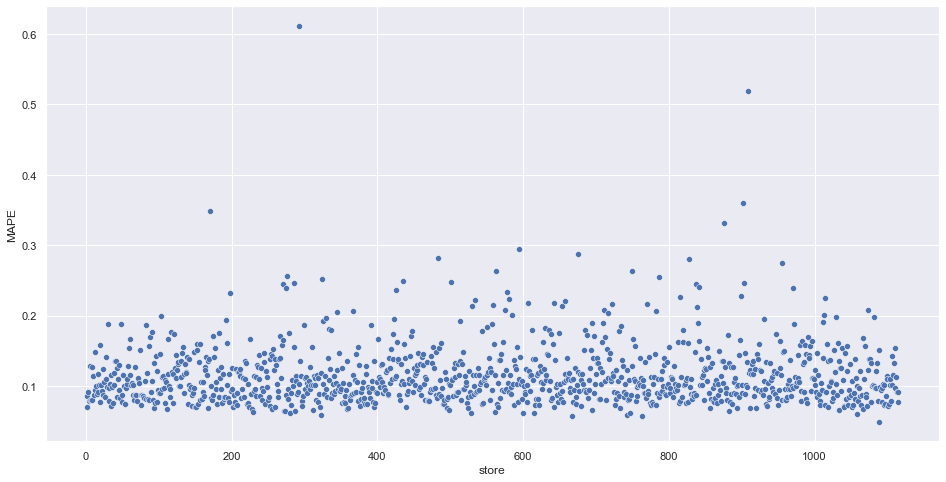

In [128]:
sns.scatterplot( x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [131]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenarios', 0: 'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$286,559,328.00"
1,worst_scenario,"R$285,703,455.06"
2,best_scenario,"R$287,415,190.64"


## 9.3. Machine Learning Performance

In [133]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

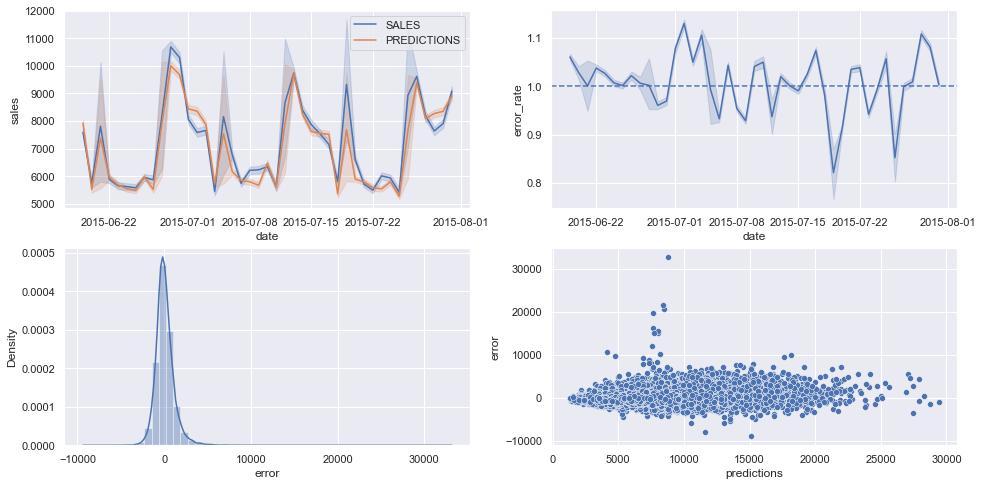

In [137]:
plt.subplot ( 2, 2, 1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot ( 2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'])

plt.subplot( 2, 2, 4)
sns.scatterplot( df9['predictions'], df9['error'])

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [139]:
# Save Trainded Model
pickle.dump(model_xgb_tuned, open('/Users/arthurvale/Docs/ComunidadeDS/DSEmProducao/Rossman-Forcast-Sales/model/model_rossaman.pkl', 'wb'))

## 10.1. Rossmann Class
Limpeza, Transformaçao e encoding

In [ ]:
class Rossmann( object ):
    def __init__( self ):
        self.competition_distance_scaler    = pickle.load( open( 'parameters/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler  = pickle.load( open( 'parameters/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler         = pickle.load( open( 'parameters/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                    = pickle.load( open( 'parameters/year_scaler.pkl', 'rb') )
        self.store_type_scaler              = pickle.load( open( 'parameters/store_type_scaler.pkl', 'rb' ) )

        
    
    def data_cleaning( self, df1 ):
        
        ## 1.1. Rename Columns 
        
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )
        
        # rename 
        df1.columns = cols_new

        ## 1.3. Data Types 
        
        df1['date'] = pd.to_datetime( df1['date'] )
        
        ## 1.5. Fillout NA
        
        # competition_distance 
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        # competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1)

        # competition_open_since_year  
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)

        # promo2_since_week  
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)

        # promo2_since_year 
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)

        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis= 1 )
        
        ## 1.6. Change Data Types 
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        #promo2 
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        
        return df1
    
    def feature_engineering( self, df2 ): 
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis= 1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply(lambda x: x.days).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' ) 

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        ## 3.0. Filtragem das Variaveis
        ## 3.1. Filtragem das Linhas
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0 )]
        
        ## 3.2. Selecao das Colunas
        cols_drop = ['customers' , 'open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis= 1 )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        
        ## 5.3.1. Enconding
        #state_holiday - One Hot Encoding - representa um "estado"
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding - como nao sabemos se há uma ordem ordenamos aleatoriamente 
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding - Basic parece ser maior que Extra e menor que Extended
        assortment_dic = {'basic': 1, 'extra': 2, 'extended':3}
        df5['assortment'] = df5['assortment'].map( assortment_dic )
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x *( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x *( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x *( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x *( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x *( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x *( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x *( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x *( 2. * np.pi/52 ) ) )
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                        'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week',
                        'day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']        
        
        return df5[ cols_selected ]
    

## 10.2. API Handler
Utilizaçao da biblioteca flask

In [165]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model 
model = pickle.load( open('/Users/arthurvale/Docs/ComunidadeDS/DSEmProducao/Rossman-Forcast-Sales/model/model_rossaman.pkl', 'rb'))

# initialize API
app = Flask( __name__)

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance( test_json, dict ): #unique example
        test_raw = pd.DataFrame( test_json, index=[0] )
        
        else: #multiple example
        test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossmann class 
        pipeline = Rossmann()
            
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation 
        df3 = pipeline.data_preparation( df2 )
        
        # prediction 
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype= 'application/json' )


if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3 API Tester